# Final Project - CS 181

**Deliverable #3**: Data Storage and Analysis

**Name**: Hieu Tran

**Central Question**: Do countries with better environmental quality generally have stronger economies?

---

In [1]:
# import required modules
import os
import os.path
import json
import pandas as pd
from lxml import etree
from lxml import html
import sqlalchemy as sa
import matplotlib.pyplot as plt
import numpy as np

# load SQL Magic
%load_ext sql

**Setting credentials**

In [2]:
def getsqlite_creds(dirname=".",filename="creds.json",source="sqlite"):
    """ Using directory and filename parameters, open a credentials file
        and obtain the two parts needed for a connection string to
        a local provider using the "sqlite" dictionary within
        an outer dictionary.  
        
        Return a scheme and a dbfile
    """
    assert os.path.isfile(os.path.join(dirname, filename))
    with open(os.path.join(dirname, filename)) as f:
        D = json.load(f)
    sqlite = D[source]
    return sqlite["scheme"], sqlite["dbdir"], sqlite["database"]

def buildConnectionString(source="sqlite_gdpeco"):
    scheme, dbdir, database = getsqlite_creds(source=source)
    template = '{}:///{}/{}.db'
    return template.format(scheme, dbdir, database)

In [3]:
# Build the connection string
cstring = buildConnectionString("sqlite_gdpeco")
print("Connection string:", cstring)

# Establish connection from client to server
%sql $cstring

Connection string: sqlite:///./gdpeco.db


Our data is stored in `gdpeco.db`, which contains contains one table named `indicators` where our data is located, consisting of four columns corresponding to four fields (`countryname` - unique country name, primary key; `region` - world region where a country is located; `gdpvalue` - GDP per capita of a country; `ecologicalvalue` - ecological footprint of a country) 

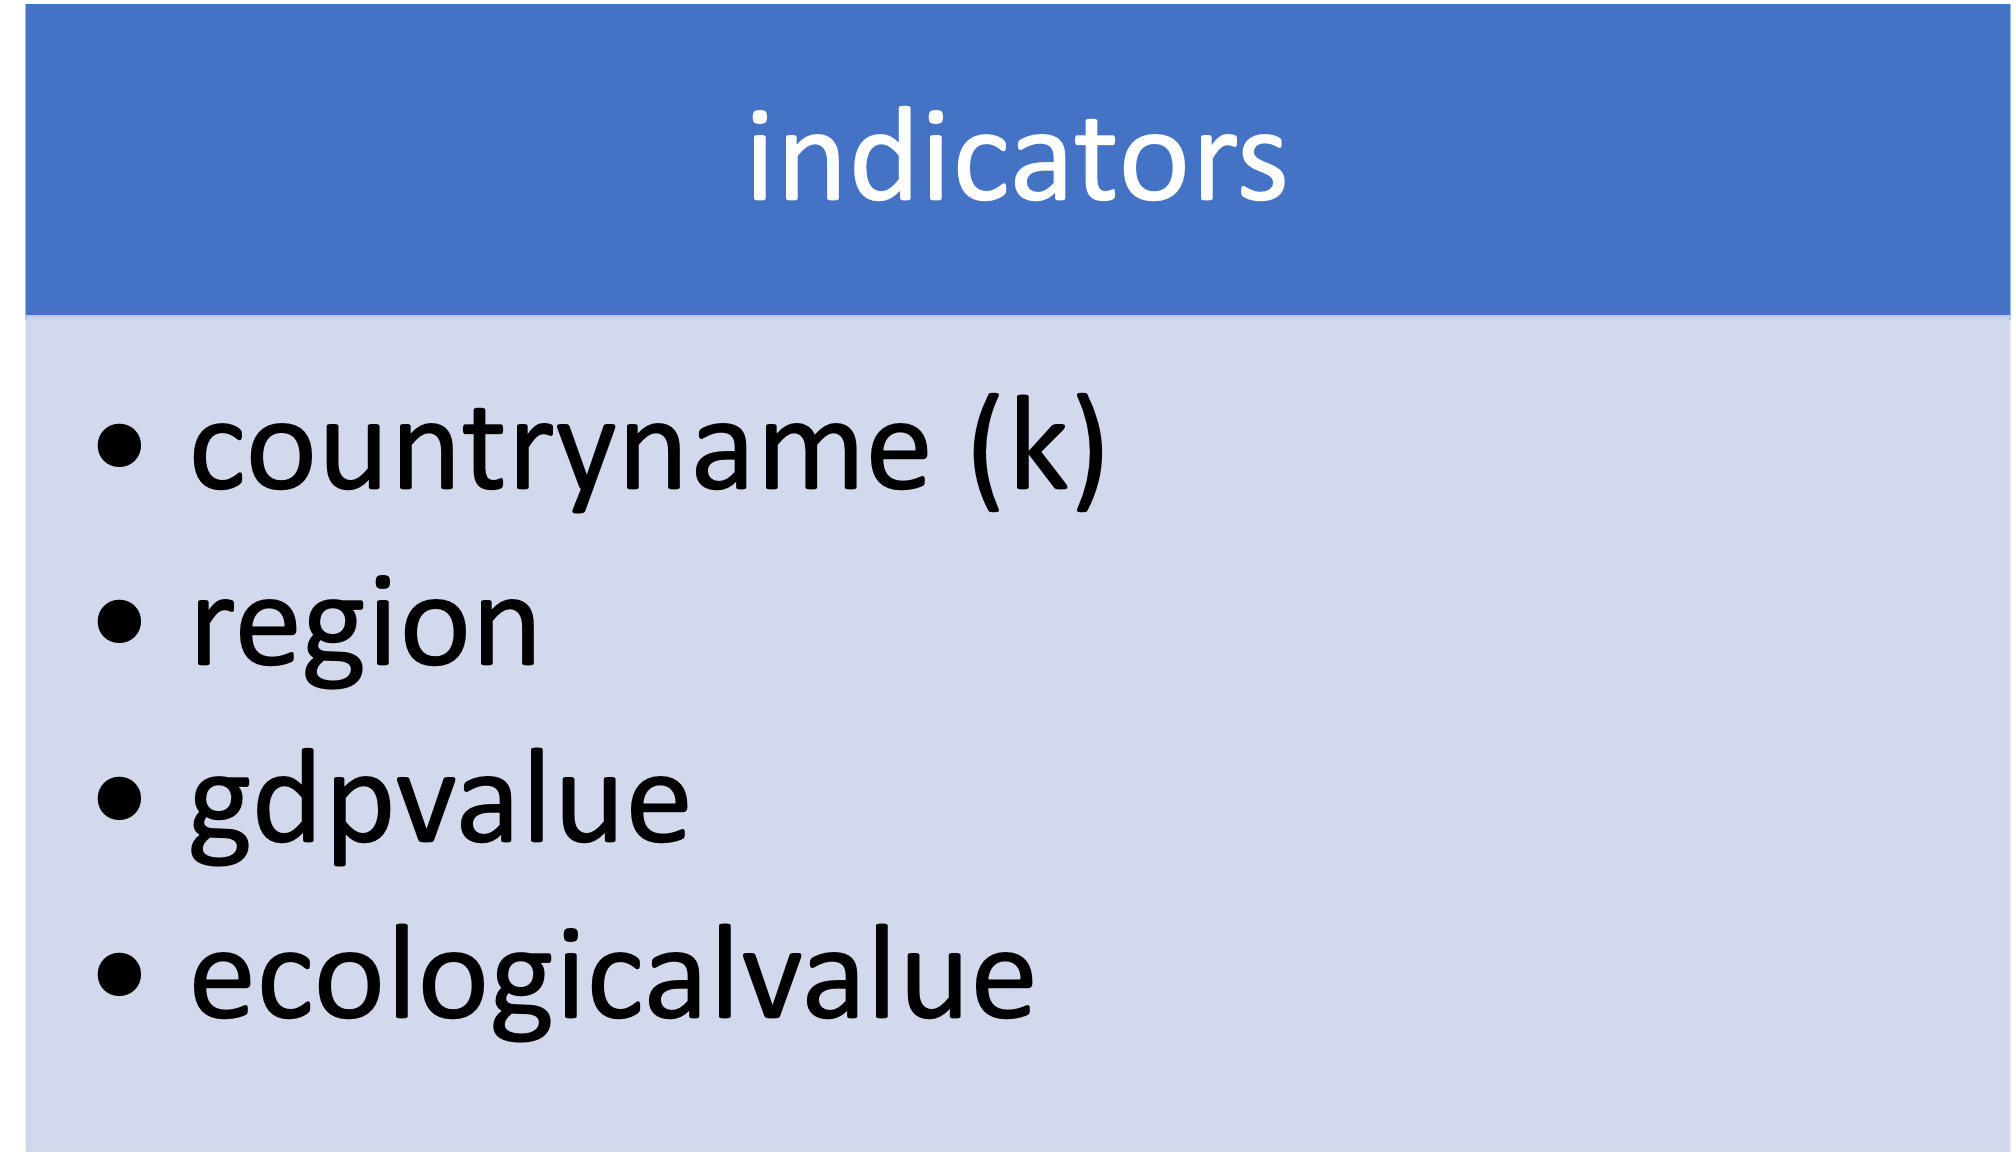

In [4]:
from IPython.display import Image
Image("indicators.png", width=600, height=600)

---

**Query 1:** First, we will query our entire table and create a scatterplot between the two variables (`gdpvalue` and `ecologicalvalue`). We will be able to visualize the data as well as calculate a correlation coefficient and see the level of correlation between the two variables.

In [5]:
query1 = """
SELECT *
FROM indicators
"""

result1 = %sql $query1
resultdf1 = result1.DataFrame()
resultdf1

 * sqlite:///./gdpeco.db
Done.


,countryname,region,gdpvalue,ecologicalvalue
0,Luxembourg,Europe,127673,15.82
1,Ireland,Europe,102217,5.57
2,Norway,Europe,92646,4.98
3,Switzerland,Europe,92434,5.79
4,Qatar,Asia,82887,10.80
...,...,...,...,...
164,Madagascar,Africa,522,0.99
165,Central African Republic,Africa,496,1.24
166,Sierra Leone,Africa,494,1.24
167,Afghanistan,Asia,611,0.79


Text(0.5, 1.0, 'Ecological footprint vs GDP per capita')

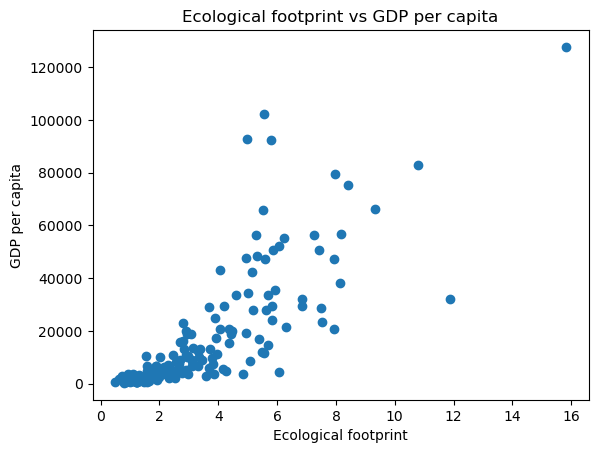

In [6]:
# Grab the variables
ecovalue = resultdf1["ecologicalvalue"]
gdpvalue = resultdf1["gdpvalue"]

# Create a scatterplot (using matplotlib)
plt.scatter(ecovalue, gdpvalue)

plt.xlabel('Ecological footprint')
plt.ylabel('GDP per capita')
plt.title('Ecological footprint vs GDP per capita')


In [7]:
# Calculate the correlation coefficient
correlation = gdpvalue.corr(ecovalue)
print("Correlation coefficient: " + str(round(correlation, 2)))

Correlation coefficient: 0.8


A correlation coefficient of .8 indicates a fairly strong positive relationship between two variables, meaning that as GDP increases, ecological footprint tends to increase as well. While the result is interesting, correlation does not necessarily imply causation, at least without further analysis that consists of other variables or real-life experiments. For the purpose of this project, we will be using other queries to better illustrate the result we got.

**Query 2:** In this query, we will compare the average GDP of countries with ecological footprint above and below the global average. 

The `CASE` expression (https://dev.mysql.com/doc/refman/5.7/en/case.html) is utilized to list the two categories of ecological footprint. 

In [8]:
query2 = """
SELECT 
    CASE WHEN ecologicalvalue < (SELECT AVG(ecologicalvalue) FROM indicators)
        THEN 'Below Average'
        ELSE 'Above Average'
    END AS ecofootprint_category,
    ROUND(AVG(gdpvalue), 2) AS average_gdp
FROM indicators
GROUP BY ecofootprint_category
"""

result2 = %sql $query2
resultdf2 = result2.DataFrame()
resultdf2

 * sqlite:///./gdpeco.db
Done.


,ecofootprint_category,average_gdp
0,Above Average,34976.68
1,Below Average,4945.13


This result shows a large difference between the average GDP of countries with an above average ecological footprint versus those with a below average ecological footprint.

**Query 3:** Here, we group our data by world region and get the average statistics for each.

In [9]:
query3 = """
SELECT region, ROUND(AVG(gdpvalue), 2) AS average_gdp, 
    ROUND(AVG(ecologicalvalue), 2) AS average_ecofootprint
FROM indicators
GROUP BY region
ORDER BY average_gdp DESC
"""

result3 = %sql $query3
resultdf3 = result3.DataFrame()
resultdf3

 * sqlite:///./gdpeco.db
Done.


,region,average_gdp,average_ecofootprint
0,Europe,35995.81,5.08
1,Oceania,17979.38,3.68
2,Asia,16538.27,3.53
3,Americas,14654.94,3.72
4,Africa,2598.74,1.65


The result shows that, relatively speaking, the higher the average GDP of a region, the higher its ecological footprint. Europe - region with highest average GDP - has the highest average ecological footprint, while the reverse is true for Africa.

**Query 4:** In this query, we get the top 5 countries with the highest and lowest GDP to ecological footprint ratio, which measures how much economic output is produced for each unit of ecological impact. The countries are ordered in a descending order based on their results.

In [10]:
query4 = """
SELECT * 
FROM(SELECT countryname, region, ROUND(gdpvalue / ecologicalvalue, 2) AS gdp_to_ecofootprint_ratio 
    FROM indicators 
    ORDER BY gdp_to_ecofootprint_ratio DESC 
    LIMIT 5)

UNION

SELECT * 
FROM(SELECT countryname, region, ROUND(gdpvalue / ecologicalvalue, 2) AS gdp_to_ecofootprint_ratio  
    FROM indicators 
    ORDER BY gdp_to_ecofootprint_ratio ASC 
    LIMIT 5)

ORDER BY gdp_to_ecofootprint_ratio DESC
"""

result4 = %sql $query4
resultdf4 = result4.DataFrame()
resultdf4

 * sqlite:///./gdpeco.db
Done.


,countryname,region,gdp_to_ecofootprint_ratio
0,Norway,Europe,18603.61
1,Ireland,Europe,18351.35
2,Switzerland,Europe,15964.42
3,Denmark,Europe,11926.13
4,Netherlands,Europe,10662.50
5,Somalia,Africa,434.68
6,Central African Republic,Africa,400.00
7,Sierra Leone,Africa,398.39
8,Burundi,Africa,366.25
9,Niger,Africa,359.62


Through this result, we can determine the most and least "efficient" economies in terms of ecological impact. It seems that the most efficient countries are in Europe - the region with the highest average GDP, whereas the least efficient countries are in Africa - the region with the lowest average GDP (query 3).

---
## **Conclusion**
- Based on the results we got, it can be reasonably concluded that **countries with better environmental quality  generally *have* stronger economies.**
- This conclusion can be reached based on the following information:
    - The correlation coefficient (query 1);
    - The average GDP for countries that have an above average ecological footprint versus those that are below average (query 2);
    - The average GDP and ecological footprint of each world region (query 3);
    - The top and bottom 5 countries with regards to their GDP to ecological footprint ratio (query 4).
